In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import zscore
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure3/output_fig3/'

from scripts.io_library import MyLib
from scripts.visualization import MyVisualization
from scripts.utils import Utils
from scripts.invoking_R_functions import MyRFunctions
from scripts.clustering_utils import Clustering

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
all_gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
all_gene_effect_df = all_gene_effect_df.T
all_gene_effect_df = all_gene_effect_df.dropna(axis=1)
all_gene_effect_df = all_gene_effect_df.rename(columns={c:c.split(' (')[0] for c in all_gene_effect_df.columns})

upset_file = 'cell_lines_master_upset_2025-2-24.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[raw_upset_df['Subtype'] != 'HCC']
upset_df = upset_df[["Subtype", 'DepMap_ID', 'RNA', 'CRISPR']]
print(f'upset shape: {upset_df.shape}')

crispr_upset_df = raw_upset_df[(raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype'] != 'HCC')]
gene_effect_df = all_gene_effect_df.loc[crispr_upset_df.index,:]
print(f'gene effect shape: {gene_effect_df.shape}')

rna_file = 'Main_Data/RNA/rna_cell_lines.csv'
all_rna_df = MyLib.load_csv(rna_file, index_col=0).T

rna_upset_df = raw_upset_df[(raw_upset_df['RNA']==1) & (raw_upset_df['Subtype'] != 'HCC')]
rna_df = all_rna_df.loc[rna_upset_df.index, :]
rna_fold_df = rna_df.apply(lambda x:x-x.median())
print(f'rna shape: {rna_df.shape}')


input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 11)

upset shape: (63, 4)
gene effect shape: (39, 17787)
input_data/Main_Data/RNA/rna_cell_lines.csv  is loaded, shape:  (17649, 79)

rna shape: (56, 17649)


# DepMap Dataset

In [4]:
ccle_cripsr_file = 'Additional_Data/DepMap/CRISPRGeneEffect.csv'
ccle_crispr_df = MyLib.load_csv(ccle_cripsr_file, index_col=0)
ccle_crispr_df = ccle_crispr_df.dropna(axis=1)
ccle_crispr_df = ccle_crispr_df.rename(columns={c:c.split(' (')[0] for c in ccle_crispr_df.columns})
print(f'ccle_crispr_df shape:{ccle_crispr_df.shape}')

other_ccle_crispr_df = ccle_crispr_df[~ccle_crispr_df.index.isin(upset_df['DepMap_ID'])]
print(f'other_ccle_crispr_df shape:{other_ccle_crispr_df.shape}')

ccle_rna_file = 'Additional_Data/DepMap/RNA_20Q2/CCLE_expression.csv'
ccle_rna_df = MyLib.load_csv(ccle_rna_file, index_col=0)
ccle_rna_df = ccle_rna_df.drop(['ACH-000052']) # Not part of the initial dataset
ccle_rna_df = ccle_rna_df.dropna(axis=1)
ccle_rna_df = ccle_rna_df.rename(columns={c:c.split(' (')[0] for c in ccle_rna_df.columns})
ccle_rna_fold_df = ccle_rna_df.apply(lambda x:x-x.median())
print(f'ccle_rna_df shape: {ccle_rna_df.shape}')

other_ccle_rna_df = ccle_rna_df[~ccle_rna_df.index.isin(upset_df['DepMap_ID'])]
other_ccle_rna_fold_df = ccle_rna_fold_df.loc[other_ccle_rna_df.index]
# other_ccle_rna_df, t = Utils.match_rows_df(ccle_rna_df, other_ccle_crispr_df)
print(f'other_ccle_rna_df shape: {other_ccle_rna_df.shape}')

input_data/Additional_Data/DepMap/CRISPRGeneEffect.csv  is loaded, shape:  (1100, 18443)

ccle_crispr_df shape:(1100, 17107)
other_ccle_crispr_df shape:(1061, 17107)
input_data/Additional_Data/DepMap/RNA_20Q2/CCLE_expression.csv  is loaded, shape:  (1305, 19144)

ccle_rna_df shape: (1304, 19144)
other_ccle_rna_df shape: (1264, 19144)


Colors

In [5]:
points_color = '#6b676e'
line_color = '#C1914B'#'#a63603'
maroon_color = '#A00000' # '#75311E'
base_color = '#d4d4d4'

# BTC vs Other DepMap differential dependency

In [6]:
gene_effect_df.shape

(39, 17787)


File  Figure3/output_fig3/gene_effects_BTC_vs_Other_DepMap.csv saved, shape: (17107, 7)


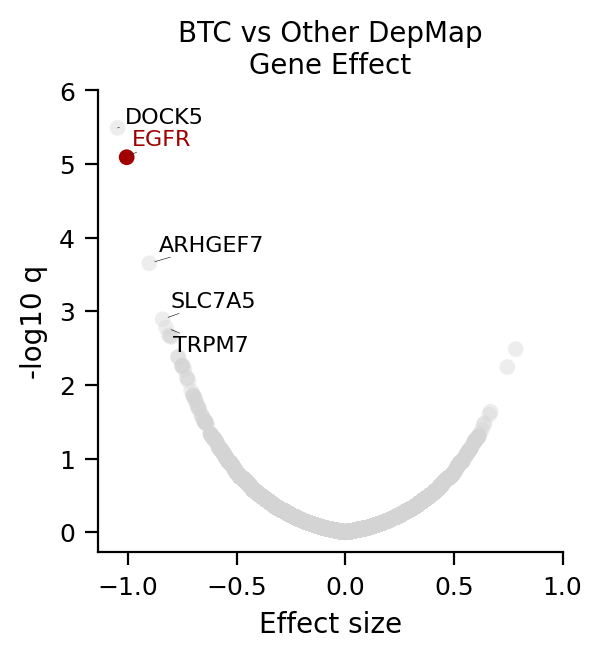

,stat,p-value,effect_size,feature,q-value,in_group_gene_effect_mean,out_group_gene_effect_mean,color
4121,-6.430734,1.890992e-10,-1.048496,DOCK5,0.000003,-0.319410,-0.083993,NaN
4416,-6.172225,9.459049e-10,-1.006348,EGFR,0.000008,-0.739691,-0.368630,#A00000
938,-5.534250,3.907537e-08,-0.902329,ARHGEF7,0.000223,-0.668984,-0.354682,NaN
13493,-5.155362,3.000705e-07,-0.840554,SLC7A5,0.001283,-0.564254,-0.265433,NaN
15499,-5.061910,4.863965e-07,-0.825317,TRPM7,0.001664,-1.183354,-0.815845,NaN
...,...,...,...,...,...,...,...,...
9303,0.000643,9.994874e-01,0.000105,NACC1,0.999816,-0.060096,-0.060113,NaN
6472,-0.000523,9.995828e-01,-0.000085,HLA-DPA1,0.999816,0.032181,0.032190,NaN
6605,0.000477,9.996197e-01,0.000078,HPS3,0.999816,-0.015032,-0.015043,NaN
10792,-0.000284,9.997736e-01,-0.000046,PJA1,0.999832,-0.011335,-0.011330,NaN


In [7]:
selected_genes_dic = {'EGFR':maroon_color}
Utils.statistical_test_and_volcano_plot(gene_effect_df, other_ccle_crispr_df, selected_genes_dic=selected_genes_dic, force_points=4, title='BTC vs Other DepMap\nGene Effect', xlim_right=1, ylim_top=6, cut_off_labels=4, force_text=.5, xlabel='Effect size', save_file='gene_effects_BTC_vs_Other_DepMap.csv', save_figure=True)

# EGFR Dependency 

In [8]:
color_dic = {'Other DepMap': {'Other DepMap': base_color}, 'BTC all':{'BTC all': maroon_color}}
color_rug_dic = color_dic
gene = 'EGFR'

df, p_value = Utils.prepare_data_for_hue_plots(ccle_crispr_df[[gene]], upset_df.set_index('DepMap_ID'), label1='BTC all', label2='Other DepMap', id_vars='index', reverse_groups=True)
df = df.rename(columns={'value': 'Gene Effect'})
print('p-value: ', p_value)

p-value:  9.459048740938651e-10


Figure3/output_fig3/EGFR_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

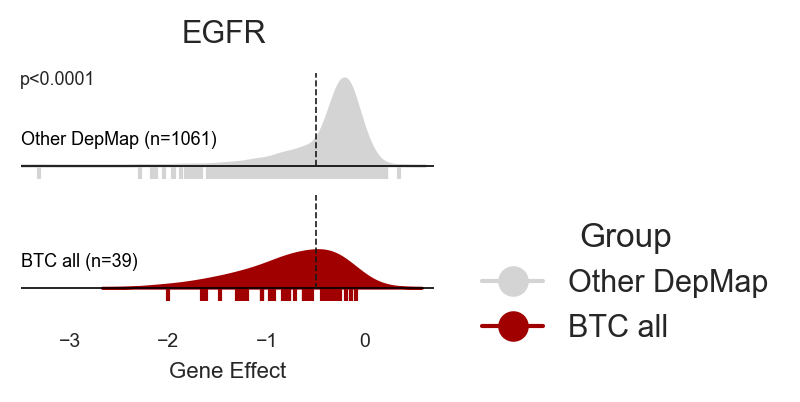

In [9]:
MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_right=0.7, xlim_left=-3.5, aspect=3, title='EGFR', p_value_l=[p_value], vline_offset=0.16, xtick_step=1, rug_plot_height=0.3, file_name=gene)

Only BTC EGFR WT

In [10]:
egfr_cell_lines = ['TGBC1TKB', 'ECC3', 'YSCCC']
print('Gene effect of BTC EGFR altered cell lines:')
gene_effect_df.loc[egfr_cell_lines, 'EGFR']

Gene effect of BTC EGFR altered cell lines:


Cell_line
TGBC1TKB   -1.043033
ECC3       -1.270041
YSCCC      -0.575871
Name: EGFR, dtype: float64

Figure3/output_fig3/EGFR_wt_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

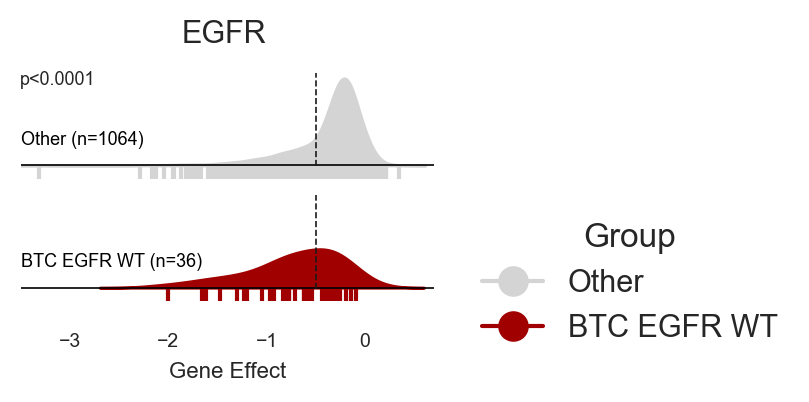

In [11]:
temp_upset_df = upset_df.drop(egfr_cell_lines, axis=0)

color_dic = {'Other': {'Other': '#d4d4d4'}, 'BTC EGFR WT':{'BTC EGFR WT': maroon_color}}#CED5E0
color_rug_dic = color_dic
gene = 'EGFR'

df, p_value = Utils.prepare_data_for_hue_plots(ccle_crispr_df[[gene]], temp_upset_df.set_index('DepMap_ID'), label1='BTC EGFR WT', label2='Other', id_vars='index', reverse_groups=True)
df = df.rename(columns={'value': 'Gene Effect'})

MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_right=0.7, xlim_left=-3.5, aspect=3, title='EGFR', p_value_l=[p_value], vline_offset=0.16, xtick_step=1, rug_plot_height=0.3, file_name=f'{gene}_wt')

Only BTC EGFR Mutants

Figure3/output_fig3/EGFR_mt_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

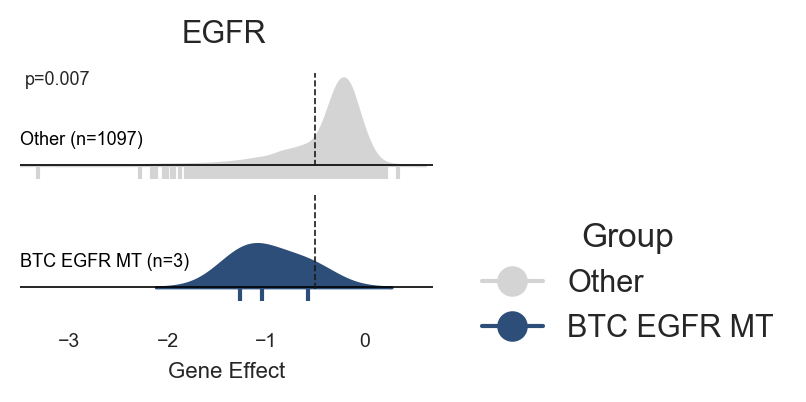

In [12]:
egfr_cell_lines = ['TGBC1TKB', 'ECC3', 'YSCCC']
temp_upset_df = upset_df.loc[egfr_cell_lines]

color_dic = {'Other': {'Other': '#d4d4d4'}, 'BTC EGFR MT':{'BTC EGFR MT': '#2C4E78'}}
color_rug_dic = color_dic
gene = 'EGFR'

df, p_value = Utils.prepare_data_for_hue_plots(ccle_crispr_df[[gene]], temp_upset_df.set_index('DepMap_ID'), label1='BTC EGFR MT', label2='Other', id_vars='index', reverse_groups=True)
df = df.rename(columns={'value': 'Gene Effect'})

MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_right=0.7, xlim_left=-3.5, aspect=3, title='EGFR', p_value_l=[p_value], vline_offset=0.16, xtick_step=1, rug_plot_height=0.3, file_name=f'{gene}_mt')

# EGFR bar chart

In [13]:
gene = 'EGFR'
egfr_crispr = ccle_crispr_df[[gene]].copy()
egfr_crispr.loc[(egfr_crispr[gene]<-0.5), 'Status'] = 'EGFR Dependent'
egfr_crispr.loc[(egfr_crispr[gene]>=-0.5), 'Status'] = 'EGFR non-Dependent'
egfr_crispr.loc[(egfr_crispr.index.isin(upset_df['DepMap_ID'])), 'Group'] = 'BTC'
egfr_crispr.loc[~(egfr_crispr.index.isin(upset_df['DepMap_ID'])), 'Group'] = 'Other DepMap'

In [14]:
egfr_cross_tab_group = pd.crosstab(index=egfr_crispr['Group'],
                             columns=egfr_crispr['Status'],
                             normalize="index")
egfr_cross_tab_group*100

Status,EGFR Dependent,EGFR non-Dependent
Group,,
BTC,64.102564,35.897436
Other DepMap,22.525919,77.474081


In [15]:
pairs_pval = Utils.fisher_test(egfr_crispr, x_col='Group', y_col='Status')
pairs_pval

Status        EGFR Dependent  EGFR non-Dependent
Group                                           
BTC                       25                  14
Other DepMap             239                 822
Odds Ratio: 6.14166168559474
P-value: 6.705964514752633e-08
There is a significant association between BTC and Other DepMap


{('BTC', 'Other DepMap'): 6.705964514752633e-08}

p-value= 6.705964514752633e-08


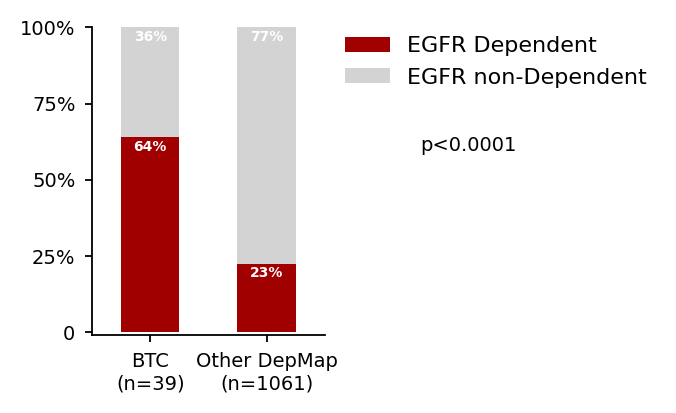

In [16]:
color_dic =  {'EGFR Dependent': maroon_color, 'EGFR non-Dependent': 'lightgrey'}
MyVisualization.percentage_stacked_barplot(egfr_crispr, x_col='Group', y_col='Status', color_dic=color_dic, figure_width=1.5, legend_fontsize=8, p_value=list(pairs_pval.values())[0], file_name='EGFR_dependency')

 # BTC: EGFR Gene Effect correlation with RNA


File  Figure3/output_fig3/egfr_rna_corr.csv saved, shape: (17550, 4)


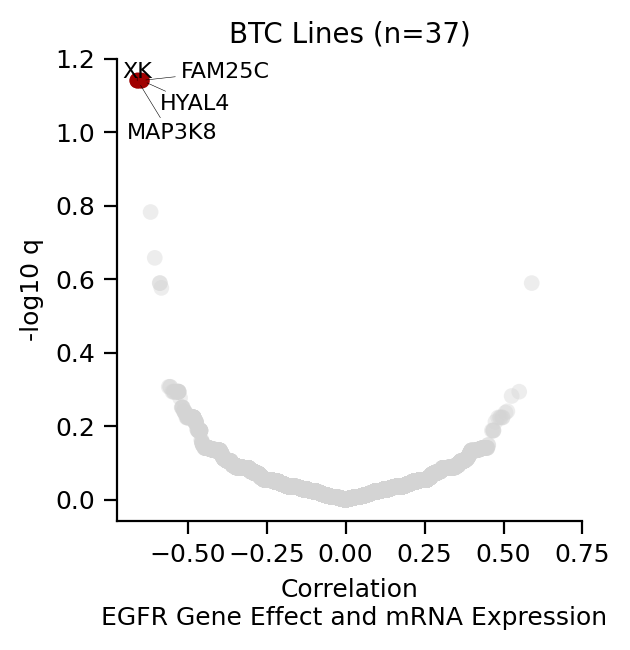

,feature,corr,p-value,q-value
Gene,,,,
ETV5,ETV5,0.589253,0.000124,0.257512
TWF2,TWF2,0.549640,0.000426,0.508522
MMP11,MMP11,0.525705,0.000833,0.522403
KDM8,KDM8,0.512113,0.001195,0.574887
HEATR3,HEATR3,0.506308,0.001387,0.579563
...,...,...,...,...
GABRP,GABRP,-0.617339,0.000047,0.164991
HYAL4,HYAL4,-0.644789,0.000017,0.072414
FAM25C,FAM25C,-0.650179,0.000013,0.072414


In [17]:
gene = 'EGFR'
rna_filtered_df, gene_effect_filtered_df = Utils.match_rows_df(rna_df, gene_effect_df)
Utils.statistical_test_and_volcano_plot(gene_effect_filtered_df[[gene]], rna_filtered_df, col=gene, test='correlation', xlabel='Correlation\n EGFR Gene Effect and mRNA Expression', save_file='egfr_rna_corr.csv', force_points=4, force_text=1, ylim_top=1.2, title=f'BTC Lines (n={rna_filtered_df.shape[0]})',axis_label_fontsize=9, xtick_step=0.25, xlim_right=.75, up_color='#077f97', down_color='#a00000', save_figure=True)

# DepMap: EGFR Gene Effect correlation with RNA


File  Figure3/output_fig3/ccle_egfr_gene_effect_corr_rna.csv saved, shape: (19115, 4)


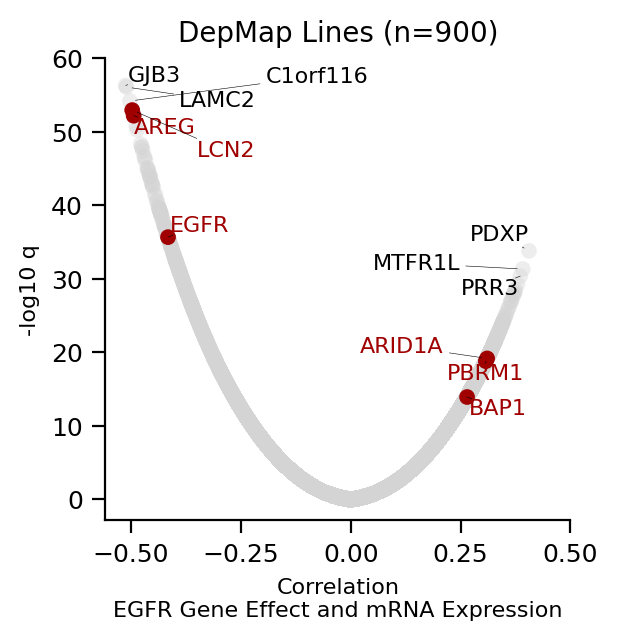

In [18]:
gene = 'EGFR'
selected_genes_dic = {'LCN2':maroon_color, 'AREG':maroon_color, 'EGFR':maroon_color, 'PBRM1':maroon_color, 'ARID1A':maroon_color, 'BAP1':maroon_color}
ccle_rna_filtered_df, ccle_cripsr_filtered_df = Utils.match_rows_df(ccle_rna_df, ccle_crispr_df)
corr_res_df = Utils.statistical_test_and_volcano_plot(ccle_cripsr_filtered_df[[gene]], ccle_rna_filtered_df, col=gene, test='correlation', xlabel='Correlation\nEGFR Gene Effect and mRNA Expression', ylim_top=60, xlim_right=0.5,  force_points=.6, force_text=1., selected_genes_dic=selected_genes_dic, cut_off_labels=3, save_file='ccle_egfr_gene_effect_corr_rna.csv',  title=f'DepMap Lines (n={ccle_rna_filtered_df.shape[0]})', axis_label_fontsize=8, save_figure=True)

In [19]:
corr_res_df.head()

,feature,corr,p-value,q-value,color
PDXP,PDXP,0.405505,6.083159e-37,1.592871e-34,NaN
MTFR1L,MTFR1L,0.391481,2.455572e-34,4.647352e-32,NaN
PRR3,PRR3,0.385810,2.564553e-33,4.189866e-31,NaN
SRM,SRM,0.379275,3.617852e-32,5.279027e-30,NaN
RBM10,RBM10,0.374565,2.348091e-31,3.138725e-29,NaN


# EGFR dependency vs frequently deleted genes

## GISTIC Peaks

In [20]:
gistic_tcga_file = 'Patients_Data/TCGA-CN/del_genes.conf_99.txt'
gistic_tcga_df = MyLib.load_tsv(gistic_tcga_file)
gistic_tcga_df = gistic_tcga_df.iloc[3:, 1:17]

input_files/Patients_Data/TCGA-CN/del_genes.conf_99.txt  is loaded, shape:  (1017, 19)



In [21]:
gistic_genes_dic = dict()
gistic_genes = set()
for band in gistic_tcga_df.columns:
    band_genes_l = sorted(set(gistic_tcga_df[band].dropna()))
    genes_l = [g for g in band_genes_l if g in rna_df.columns]
    gistic_genes_dic[band] = genes_l
    gistic_genes.update(genes_l)
gistic_genes_l = list(gistic_genes)
print('Number of gistic genes:', len(gistic_genes_l))

Number of gistic genes: 3326


In [22]:
corr_res_gistic_genes_sr = corr_res_df['corr'].copy()
corr_res_gistic_genes_sr.sort_values(ascending=False, inplace=True)
corr_res_gistic_genes_sr.head()

PDXP      0.405505
MTFR1L    0.391481
PRR3      0.385810
SRM       0.379275
RBM10     0.374565
Name: corr, dtype: float64

In [23]:
gistic_genes_dic.keys()

dict_keys(['1p36.21', '4q34.3', '9p21.3', '6q13', '14q22.1', '3p13', '3p25.3', '10q26.12', '11q25', '12q24.13', '13q21.32', '14q32.11', '9q21.11', '5q13.3', '16q23.1', '14q32.33'])

In [24]:
fgsea_res_df = MyRFunctions.fgsea(gistic_genes_dic, corr_res_gistic_genes_sr)

In [25]:
fgsea_res_filtered_df = fgsea_res_df[['pathway', 'NES', 'padj']].copy()
fgsea_res_filtered_df.sort_values(by='NES', ascending=False, inplace=True)
fgsea_res_filtered_df.set_index('pathway', inplace=True, drop=True)
fgsea_res_df

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge
1,10q26.12,8.275862e-01,8.275862e-01,0.204295,-0.158350,-0.927078,288,"c(""COL17A1"", ""FANK1"", ""ANKRD22"", ""AVPI1"", ""MYO..."
2,11q25,6.201976e-01,7.235638e-01,0.040085,0.203286,0.937010,210,"c(""JAM3"", ""DIXDC1"", ""ATM"", ""C2CD2L"", ""NRGN"", ""..."
3,12q24.13,3.125581e-03,1.080191e-02,0.431708,0.305971,1.450279,307,"c(""FAM216A"", ""KDM2B"", ""STX2"", ""ANAPC5"", ""MPHOS..."
4,13q21.32,2.050473e-01,2.870662e-01,0.173748,-0.354814,-1.209510,18,"c(""KLF5"", ""SCEL"", ""LMO7"", ""UCHL3"")"
5,14q22.1,7.299270e-01,7.860752e-01,0.069779,-0.447049,-0.790282,3,SAV1
6,14q32.11,3.305563e-04,1.542596e-03,0.498493,-0.260256,-1.525028,286,"c(""TMEM30B"", ""PLEK2"", ""TC2N"", ""TNFAIP2"", ""IFI2..."
7,1p36.21,3.857823e-03,1.080191e-02,0.431708,0.306777,1.438510,256,"c(""MTFR1L"", ""SRM"", ""RPA2"", ""PPP1R8"", ""DNAJC8"",..."
8,3p13,5.508856e-11,3.856200e-10,0.851339,0.435940,2.034683,249,"c(""ELP6"", ""DHX30"", ""SHQ1"", ""ZNF445"", ""PXK"", ""P..."
9,3p25.3,1.871384e-12,2.619937e-11,0.898671,0.430278,2.042284,310,"c(""ELP6"", ""DHX30"", ""CLASP2"", ""SETMAR"", ""ZNF445..."
10,4q34.3,3.333333e-01,4.242424e-01,0.095288,0.726504,1.097806,2,"c(""NEIL3"", ""AGA"")"


In [26]:
MyLib.save_csv(fgsea_res_df, 'fgsea_GISTIC_peaks.csv')


File  Figure3/output_fig3/fgsea_GISTIC_peaks.csv saved, shape: (14, 8)


In [27]:
print('Number of genes common to both 3p25.3 and 3p13:', len(set(gistic_genes_dic['3p25.3']).intersection(gistic_genes_dic['3p13'])))

Number of genes common to both 3p25.3 and 3p13: 109


In [28]:
data_df = pd.DataFrame(columns=['pathway', 'corr', 'fgsea NES'])
for band, row in fgsea_res_filtered_df.iterrows():
    # band = row['pathway']
    genes = gistic_genes_dic[band]
    count = len(genes)
    cur_df = pd.DataFrame(index=genes, columns=['pathway', 'corr', 'fgsea NES'])
    cur_df['pathway'] = band
    cur_df['fgsea NES'] = row['NES']
    cur_df.loc[genes, 'corr'] = corr_res_gistic_genes_sr[genes].values.tolist()
    cur_df.reset_index(inplace=True)
    data_df = pd.concat([data_df, cur_df], axis=0)
data_df.reset_index(inplace=True, drop=True)
data_df.columns = ['Band', 'Correlation', 'fgsea NES', 'Gene']
data_df.head()

,Band,Correlation,fgsea NES,Gene
0,3p25.3,-0.026629,2.042284,ABHD5
1,3p25.3,0.034574,2.042284,ACAA1
2,3p25.3,-0.122234,2.042284,ACKR2
3,3p25.3,0.19264,2.042284,ACVR2B
4,3p25.3,-0.472925,2.042284,ALS2CL


In [29]:
fgsea_res_filtered_df['NES']

pathway
3p25.3      2.042284
3p13        2.034683
12q24.13    1.450279
1p36.21     1.438510
6q13        1.267160
5q13.3      1.154687
4q34.3      1.097806
11q25       0.937010
14q22.1    -0.790282
10q26.12   -0.927078
13q21.32   -1.209510
9q21.11    -1.230777
9p21.3     -1.342456
14q32.11   -1.525028
Name: NES, dtype: float64

In [30]:
color_dic={'3p13':'#b54007',
'3p25.3':'#cc4808',
'12q24.13':'#f2641f',
'1p36.21':'#f76a25',
'6q13':'#f77c40',
'5q13.3':'#f58047',
'4q34.3':'#f58047',
'11q25':'#f79565',
'14q22.1':'#b0a8a4',
'10q26.12':'#a19c9a',
'13q21.32':'#878483',
'9q21.11':'#878483',
'9p21.3':'#7d7b7a',
'14q32.11':'#706f6f'
}

In [31]:
fgsea_res_filtered_df['NES_str'] = fgsea_res_filtered_df['NES'].apply(lambda x: f'NES={x:.2f}')

Figure3/output_fig3/3p13_peaks_ridge_plot.pdf


<Figure size 900x600 with 0 Axes>

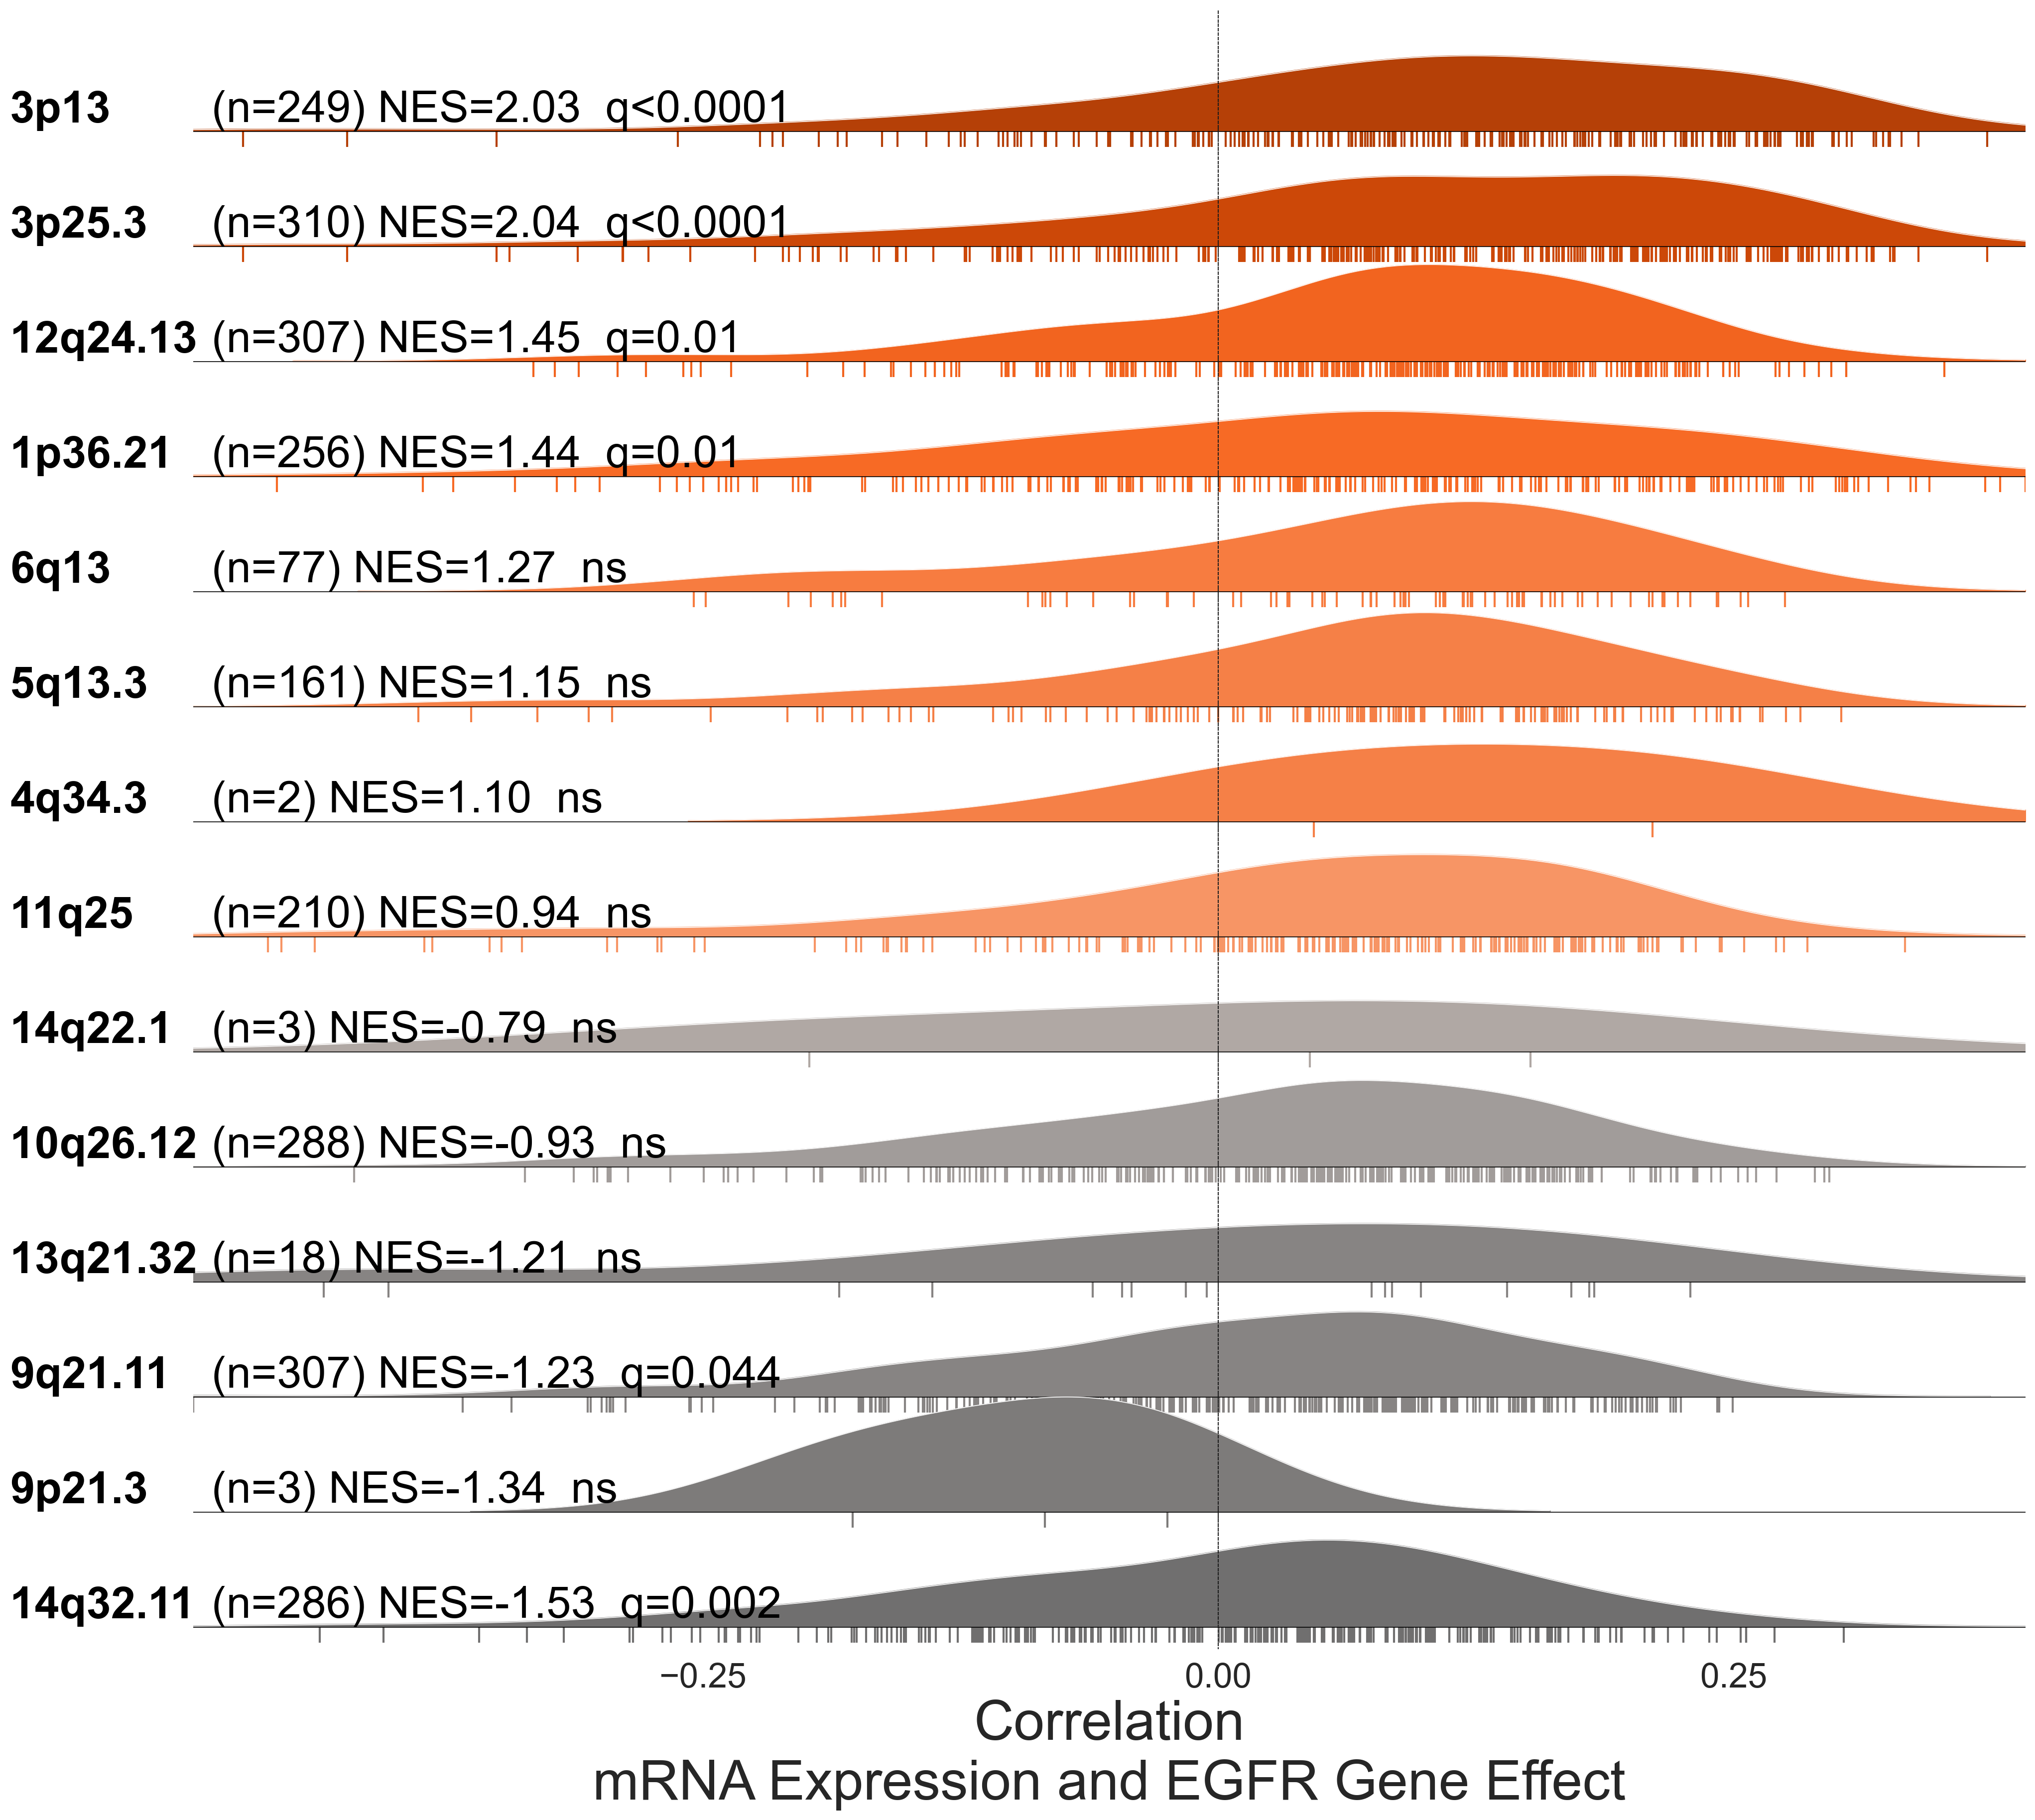

In [32]:
level_order = fgsea_res_filtered_df.index.tolist()
p_values_dic = fgsea_res_filtered_df['padj'].to_dict()
text_dic = fgsea_res_filtered_df['NES_str'].to_dict()
MyVisualization.multiple_ridge_plot(data_df, color_dic=color_dic, col_level='Band', xlim_left=data_df['Correlation'].min(), xlim_right=data_df['Correlation'].max(), text_dic=text_dic, p_value_dic=p_values_dic, adjp=True, col_score='Correlation', col_hue='fgsea NES', aspect=18, xlabel='Correlation\nmRNA Expression and EGFR Gene Effect', text_fontsize=32, xlabel_fontsize=40, tick_fontsize=25, vline_offset=-0.2, file_name='3p13_peaks')

# 3p13 GISTIC Peaks

In [33]:
arm = '3p13 Peaks'
genes_3p_l = sorted(set(gistic_tcga_df['3p13'].dropna()))#.union(set(gistic_tcga_df['3p25.3'].dropna()))
print(len(genes_3p_l))

356


In [34]:
genes_l = [g for g in genes_3p_l if g in rna_df.columns]
len(genes_l)

249

In [35]:
ssgsea_df = MyRFunctions.ssgsea(rna_fold_df.T, genes_l)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [36]:
ssgsea_df = zscore(ssgsea_df)
MyLib.save_csv(ssgsea_df, f'btc_ssgsea_zscored_{arm}_tcga.csv')


File  Figure3/output_fig3/btc_ssgsea_zscored_3p13 Peaks_tcga.csv saved, shape: (56, 1)


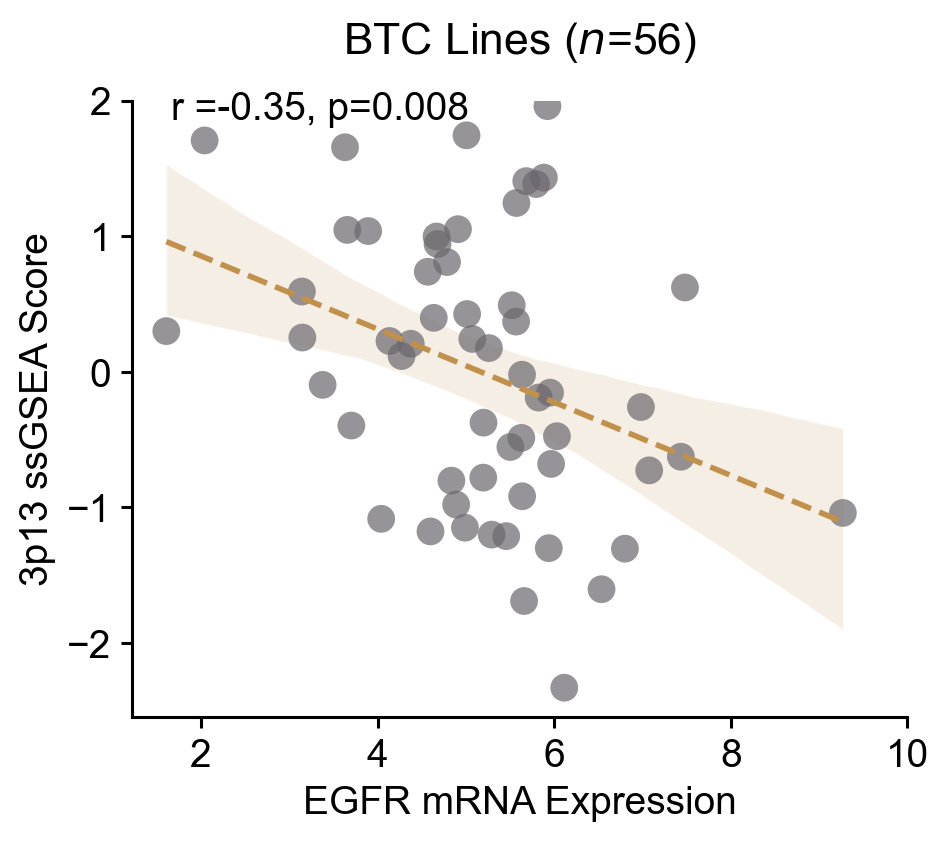

In [37]:
gene = 'EGFR'
x, y = Utils.match_rows_df(rna_df[[gene]], ssgsea_df)
df = pd.concat([x, y], axis=1)

MyVisualization.reg_plot(data_df=df, x_col=gene, y_col='ssGSEA', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'EGFR mRNA Expression', ylabel=f'3p13 ssGSEA Score',  marker='o', title_height=1.05, text_height=.97, title_fontsize=16, ylim_top=2, xlim_right=10, file_name=f'btc_mrna_ssgsea_{gene}')

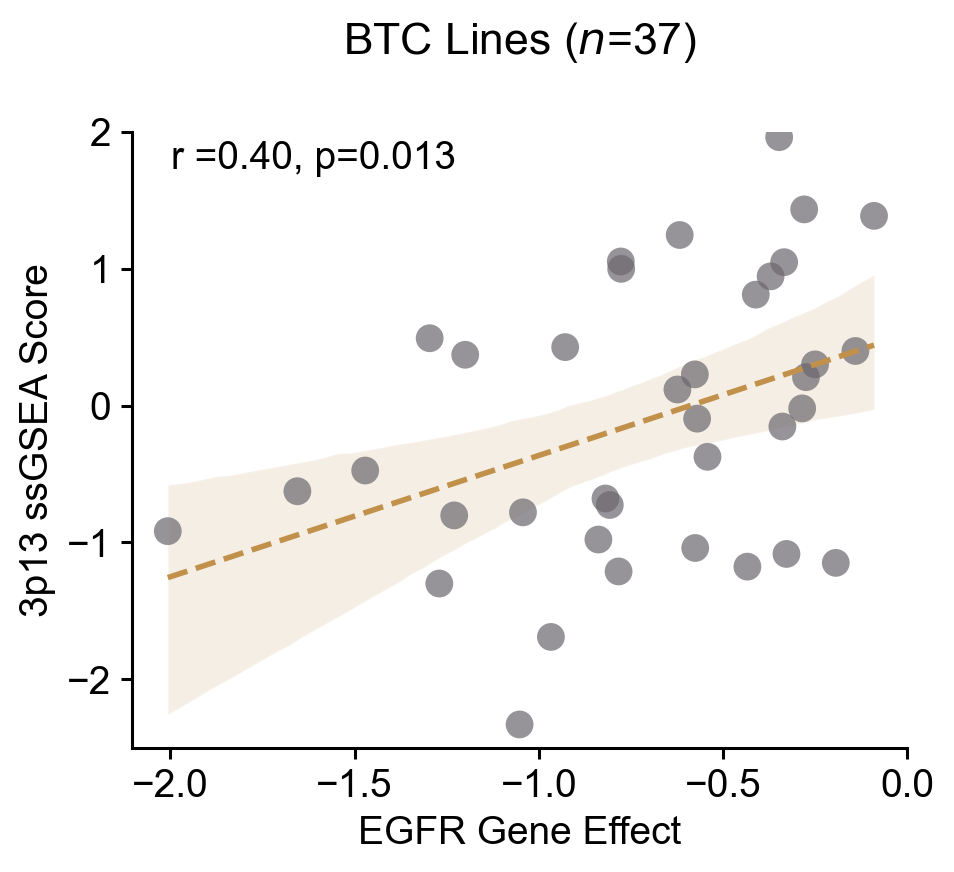

In [38]:
gene = 'EGFR'
x, y = Utils.match_rows_df(gene_effect_df[[gene]], ssgsea_df)
df = pd.concat([x, y], axis=1)

MyVisualization.reg_plot(data_df=df, x_col=gene, y_col='ssGSEA', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect', ylim_top=2., ylim_bottom=-2.5, ytick_step=1., xlim_right=0, ylabel=f'3p13 ssGSEA Score', marker='o', title_height=1.1, text_height=.94, add_legend=False, title_fontsize=16,  file_name=f'btc_chronos_ssgsea_{gene}')

## DepMap 

In [39]:
genes_l = [g for g in genes_3p_l if g in ccle_rna_df.columns]
len(genes_l)

265

In [40]:
ccle_ssgsea_df = MyRFunctions.ssgsea(ccle_rna_fold_df.T, genes_l)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [41]:
ccle_ssgsea_df = zscore(ccle_ssgsea_df)
MyLib.save_csv(ccle_ssgsea_df, f'ccle_ssgsea_zscored_{arm}.csv', index=True)
ccle_ssgsea_df.head()


File  Figure3/output_fig3/ccle_ssgsea_zscored_3p13 Peaks.csv saved, shape: (1304, 1)


,ssGSEA
ACH-001097,0.460848
ACH-001636,0.021622
ACH-001804,1.249402
ACH-000534,0.451933
ACH-001498,-0.048608


### PRISM

In [42]:
drug_names_ids_file = "Additional_Data/PRISM_Screen/Repurposing_Public_23Q2_Extended_Primary_Compound_List.csv"
drug_names_ids_df = MyLib.load_csv(drug_names_ids_file)
drug_names_ids_df['drug_id'] = drug_names_ids_df['IDs'].apply(lambda x:x.split(':')[1])
drug_names_ids_df.head()

input_data/Additional_Data/PRISM_Screen/Repurposing_Public_23Q2_Extended_Primary_Compound_List.csv  is loaded, shape:  (6658, 7)



,screen,dose,Drug.Name,repurposing_target,MOA,IDs,Synonyms,drug_id
0,REP.PRIMARY,2.5,8-BROMO-CGMP,PRKG1,PKA ACTIVATOR,BRD:BRD-A00077618-236-07-6,NaN,BRD-A00077618-236-07-6
1,REP.PRIMARY,2.5,NIFURTIMOX,NaN,DNA INHIBITOR,BRD:BRD-A00100033-001-08-9,NaN,BRD-A00100033-001-08-9
2,REP.PRIMARY,2.5,BALAGLITAZONE,PPARG,"INSULIN SENSITIZER, PPAR RECEPTOR PARTIAL AGONIST",BRD:BRD-A00147595-001-01-5,NaN,BRD-A00147595-001-01-5
3,REP.PRIMARY,2.5,FLUTRIMAZOLE,NaN,STEROL DEMETHYLASE INHIBITOR,BRD:BRD-A00218260-001-03-4,NaN,BRD-A00218260-001-03-4
4,REP.PRIMARY,2.5,KBG,MME,NEPRILYSIN INHIBITOR,BRD:BRD-A00376169-001-01-6,NaN,BRD-A00376169-001-01-6


In [43]:
prism_rep_file = 'Additional_Data/PRISM_Screen/Repurposing_Public_23Q2_Extended_Primary_Data_Matrix.csv'
prism_rep_df = MyLib.load_csv(prism_rep_file, index_col=0).T
prism_rep_df.shape

input_data/Additional_Data/PRISM_Screen/Repurposing_Public_23Q2_Extended_Primary_Data_Matrix.csv  is loaded, shape:  (6658, 919)



(919, 6658)

In [44]:
egfr_drug_file = 'Additional_Data/Selected_Lists/EGFR_drugs.csv'
egfr_curated_l = MyLib.load_csv(egfr_drug_file)['label'].tolist()
egfr_curated_l = list(set(egfr_curated_l))
print(len(egfr_curated_l))

input_data/Additional_Data/Selected_Lists/EGFR_drugs.csv  is loaded, shape:  (38, 1)

38


In [45]:
drug_names_ids_df2 = drug_names_ids_df[drug_names_ids_df['Drug.Name'].isin(egfr_curated_l)]
egfr_id_l = drug_names_ids_df2['IDs'].tolist()
print('Number of egfr drugs:', len(egfr_id_l))

Number of egfr drugs: 37


Number of cell lines and drugs: (863, 6658)

File  Figure3/output_fig3/ccle_egfr_ssgsea_3p13 Peaks_prism_corr_rna.csv saved, shape: (6658, 4)


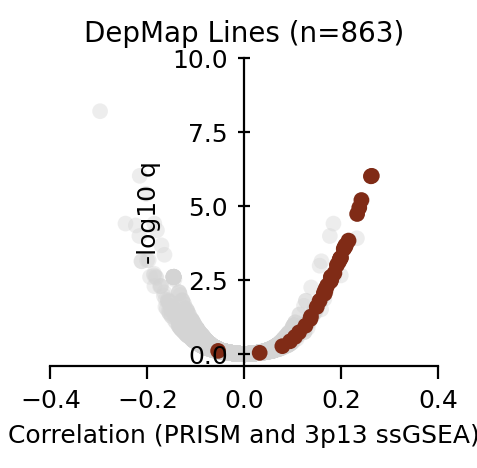

,feature,corr,p-value,q-value,color
BRD:BRD-K03765900-001-01-9.1,BRD:BRD-K03765900-001-01-9.1,0.263472,5.604678e-10,9.328987e-07,NaN
BRD:BRD-K03765900-001-01-9,BRD:BRD-K03765900-001-01-9,0.263472,5.604678e-10,9.328987e-07,#802b16
BRD:BRD-K50010139-001-02-3,BRD:BRD-K50010139-001-02-3,0.261562,7.258429e-10,9.665323e-07,#802b16
BRD:BRD-K70301465-001-02-6,BRD:BRD-K70301465-001-02-6,0.243384,7.380407e-09,6.142344e-06,NaN
BRD:BRD-K73309154-003-02-8,BRD:BRD-K73309154-003-02-8,0.242004,7.035442e-09,6.142344e-06,#802b16
...,...,...,...,...,...
BRD:BRD-K75958547-238-04-9,BRD:BRD-K75958547-238-04-9,-0.215677,3.030544e-10,9.328987e-07,NaN
BRD:BRD-K69726342-238-02-4,BRD:BRD-K69726342-238-02-4,-0.216390,2.576011e-07,1.008887e-04,NaN
BRD:BRD-K54395039-001-01-7,BRD:BRD-K54395039-001-01-7,-0.223685,9.301861e-08,4.423699e-05,NaN
BRD:BRD-K89464729-001-03-1,BRD:BRD-K89464729-001-03-1,-0.245083,7.390050e-08,3.834565e-05,NaN


In [46]:
gene = 'EGFR'
selected_genes_dic = {d:'#802b16' for d in egfr_id_l}
prism_filtered_df, ccle_ssgsea_filtered_df = Utils.match_rows_df(prism_rep_df, ccle_ssgsea_df)
print('Number of cell lines and drugs:', prism_filtered_df.shape)
Utils.statistical_test_and_volcano_plot(ccle_ssgsea_filtered_df, prism_filtered_df, col='ssGSEA', test='correlation', add_label=False, xlabel=f'Correlation (PRISM and 3p13 ssGSEA)', up_color='silver', title=f'DepMap Lines (n={prism_filtered_df.shape[0]})',down_color='silver', force_points=.6, force_text=.6, xlim_right=0.4,xlim_left=-0.4, ylim_top=10, selected_genes_dic=selected_genes_dic, yspine_center=True, title_fontsize=10, axis_label_fontsize=9, save_file=f'ccle_egfr_ssgsea_{arm}_prism_corr_rna.csv', save_figure=True, q_value=0, figure_height=2, figure_width=2.5)

Add drug names

In [47]:
prism_res_file = 'Figure3/output_fig3/ccle_egfr_ssgsea_3p13 Peaks_prism_corr_rna.csv'
prism_res_df = pd.read_csv(prism_res_file, index_col=0)
prism_res_df['feature'] = prism_res_df['feature'].apply(
    lambda x: drug_names_ids_df.loc[drug_names_ids_df['IDs'] == x, 'Drug.Name'].values[0]
    if not drug_names_ids_df.loc[drug_names_ids_df['IDs'] == x, 'Drug.Name'].empty
    else x
)
prism_res_df['EGFRi'] = prism_res_df['feature'].map(lambda x:1 if x in egfr_curated_l else np.nan)
MyLib.save_csv(prism_res_df, 'ccle_egfr_ssgsea_3p13 Peaks_prism_corr_rna.csv')


File  Figure3/output_fig3/ccle_egfr_ssgsea_3p13 Peaks_prism_corr_rna.csv saved, shape: (6658, 5)


# 3p arm loss

In [48]:
ccle_cn_file = 'Additional_Data/DepMap/OmicsCNGene.csv'
ccle_hotspot_file = 'Additional_Data/DepMap/OmicsSomaticMutationsMatrixHotspot.csv'
ccle_arm_level_file = 'Additional_Data/DepMap/arm_call_scores.csv'

ccle_cn_df = MyLib.load_csv(ccle_cn_file, index_col=0)
ccle_hotspot_df = MyLib.load_csv(ccle_hotspot_file, index_col=0)
ccle_arm_df = MyLib.load_csv(ccle_arm_level_file, index_col=0)

input_data/Additional_Data/DepMap/OmicsCNGene.csv  is loaded, shape:  (1111, 25368)

input_data/Additional_Data/DepMap/OmicsSomaticMutationsMatrixHotspot.csv  is loaded, shape:  (1111, 467)

input_data/Additional_Data/DepMap/arm_call_scores.csv  is loaded, shape:  (997, 39)



We excluded EGFR mutant and amplified cell lines from this analysis.

In [49]:
ccle_cn_filtered_df = ccle_cn_df[(ccle_cn_df.index.isin(ccle_crispr_df.index))].copy()
egfr_gain_l = ccle_cn_filtered_df[ccle_cn_filtered_df['EGFR (1956)']>=2].index.tolist()
len(egfr_gain_l)

27

In [50]:
ccle_hotspot_l = ccle_hotspot_df[ccle_hotspot_df['EGFR (1956)']==1].index.tolist()
len(ccle_hotspot_l)

8

In [51]:
exclusion_l = list(set(egfr_gain_l).union(set(ccle_hotspot_l)))
len(exclusion_l)

34

In [52]:
ccle_crispr_egfr_wt_df = ccle_crispr_df[~ccle_crispr_df.index.isin(exclusion_l)][['EGFR']].copy()

In [53]:
crispr_btc_upset_df = upset_df[(upset_df['Subtype']!='HCC') & (upset_df['CRISPR']==1)]
other_ccle_crispr_egfr_wt_df = ccle_crispr_egfr_wt_df[~ccle_crispr_egfr_wt_df.index.isin(crispr_btc_upset_df['DepMap_ID'])]
other_ccle_crispr_egfr_wt_df.shape

(1028, 1)

In [54]:
other_ccle_crispr_egfr_wt_filtered_df, other_ccle_arm_filtered_df = Utils.match_rows_df(other_ccle_crispr_egfr_wt_df, ccle_arm_df)
other_ccle_crispr_egfr_wt_filtered_df.shape

(616, 1)

In [55]:
other_ccle_arm_filtered_df[['3p']].value_counts()

3p  
 0.0    326
-1.0    261
 1.0     29
dtype: int64

In [56]:
other_ccle_3p_loss_df = other_ccle_arm_filtered_df[other_ccle_arm_filtered_df['3p']==-1][['3p']].copy()
other_ccle_3p_loss_df.shape

(261, 1)

Figure3/output_fig3/EGFR_3p_arm_ridge_plot.pdf


<Figure size 300x200 with 0 Axes>

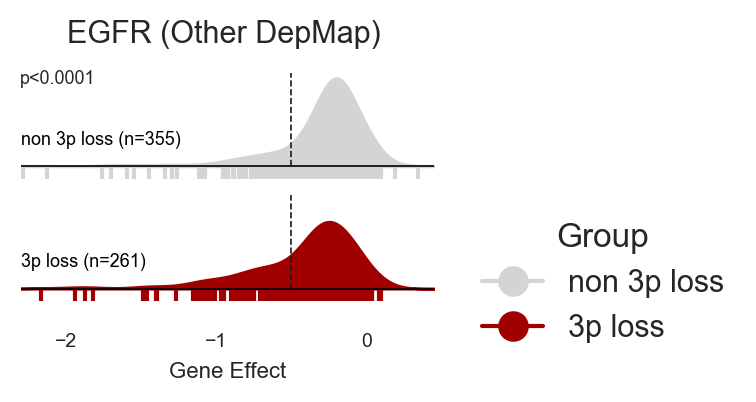

In [57]:
color_dic = {'non 3p loss': {'non 3p loss': base_color}, '3p loss':{'3p loss': maroon_color}}
color_rug_dic = color_dic
gene = 'EGFR'

df, p_value = Utils.prepare_data_for_hue_plots(other_ccle_crispr_egfr_wt_filtered_df[[gene]], other_ccle_3p_loss_df, label1='3p loss', label2='non 3p loss', id_vars='index', reverse_groups=True)
df = df.rename(columns={'value': 'Gene Effect'})

MyVisualization.ridge_plot(df, color_dic, color_rug_dic, col_hue='Group', col_level='Group', col_score='Gene Effect', xlim_right=0.45, xlim_left=-2.3, aspect=3, title='EGFR (Other DepMap)', p_value_l=[p_value], vline_offset=0.16, xtick_step=1, rug_plot_height=0.3, file_name=f'{gene}_3p_arm')

## mRNA Expression

In [58]:
other_ccle_rna_df.shape

(1264, 19144)

In [59]:
other_ccle_rna_filtered_df, other_ccle_arm_filtered_df = Utils.match_rows_df(other_ccle_rna_df, ccle_arm_df)
other_ccle_rna_filtered_df.shape

(939, 19144)

In [60]:
other_ccle_3p_loss_df = other_ccle_arm_filtered_df[other_ccle_arm_filtered_df['3p']==-1][['3p']].copy()
other_ccle_3p_loss_df.shape

(371, 1)

ranksum p-value=1.1474618062229164e-18
There is a significant association.


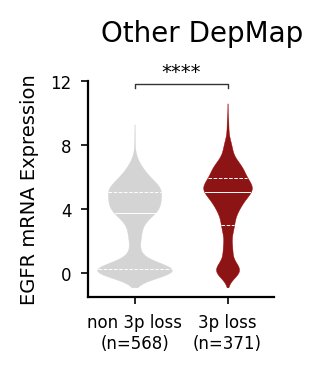

In [61]:
color_dic = {'non 3p loss': base_color, '3p loss': maroon_color}
x = 'Group'
gene = 'EGFR'

df, p_value = Utils.prepare_data_for_hue_plots(other_ccle_rna_filtered_df[[gene]], other_ccle_3p_loss_df, label1='3p loss', label2='non 3p loss', id_vars='index', reverse_groups=True)
df = df.rename(columns={'value': 'mRNA Expression'})

Utils.compare_visualize_cat_features(df, x=x, y='mRNA Expression', color_dic=color_dic, y_label=f'{gene} mRNA Expression', test='ranksum', title='Other DepMap', title_height=1.1, figure_width=1.2, figure_height=1.4, label_fontsize=7, label_newline=True, plot='violin', ylim_top=12, ytick_step=4, save_figure=True)#

# EGFR vs LCN2

In [62]:
other_ccle_crispr_df.shape

(1061, 17107)

In [63]:
other_ccle_rna_df.shape

(1264, 19144)

(864, 4)
(37, 4)
p-value:  4.1664777160410353e-50
p-value:  0.010743649571506792


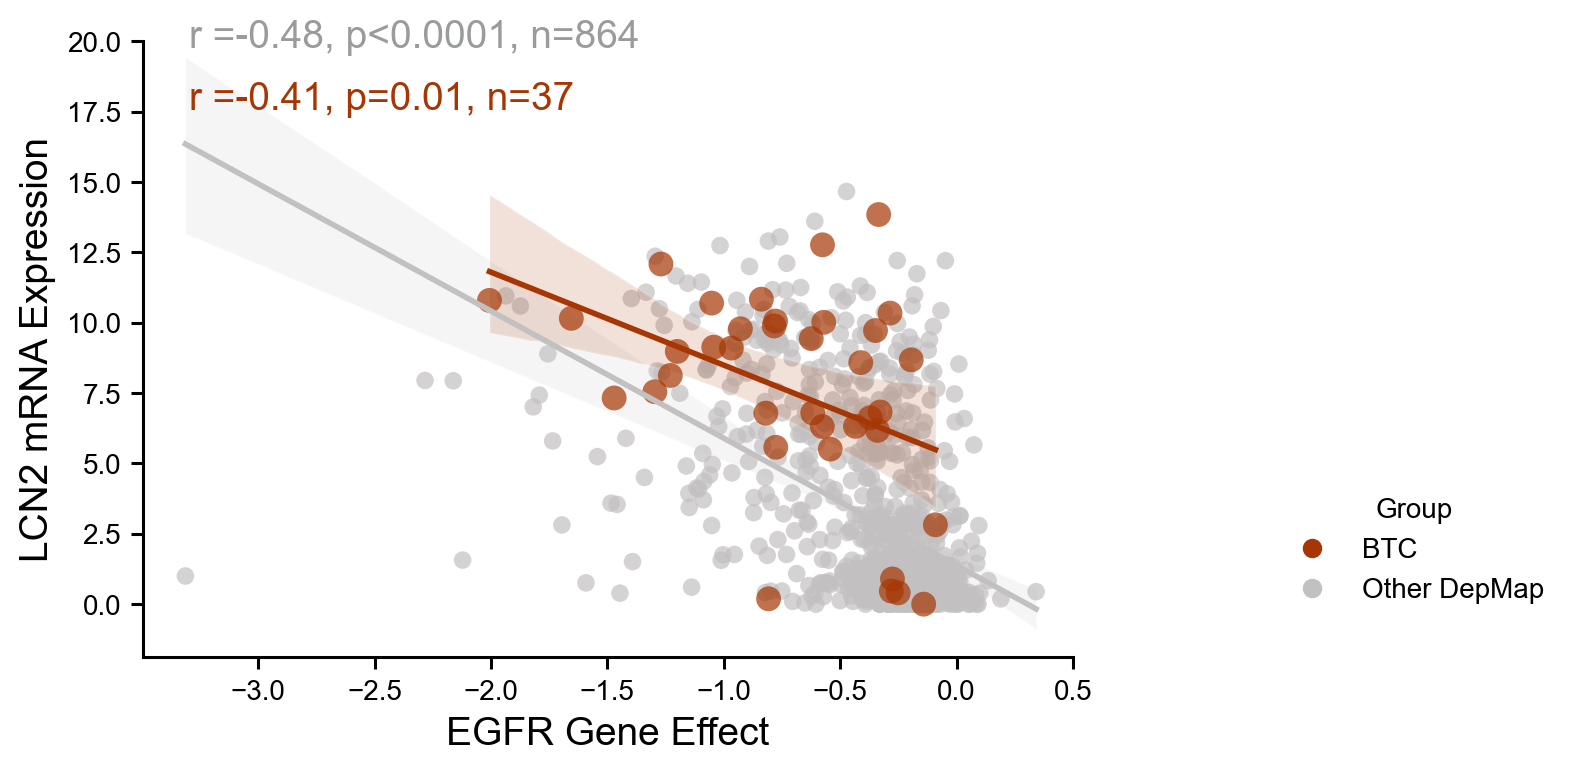

In [64]:
y_gene = 'LCN2'
x_gene = 'EGFR'
palette = {'BTC': '#a63603', 'Other DepMap': '#c2c0c0'}
size_dic = {'BTC': 80, 'Other DepMap': 40}
markers_dic = {'BTC':'o', 'Other DepMap':'o'}

x1, y1 = Utils.match_rows_df(other_ccle_crispr_df[[x_gene]], other_ccle_rna_df[[y_gene]])
x2, y2 = Utils.match_rows_df(gene_effect_df[[x_gene]], rna_df[[y_gene]])

df1 = pd.concat([x1, y1], axis=1)
df1.columns = ['gene effect', 'rna']
df1['Group'] = 'Other DepMap'
df1['point_size'] = .01
df2 = pd.concat([x2, y2], axis=1)
df2.columns = ['gene effect', 'rna']
df2['Group'] = 'BTC'
df2['point_size'] = .03

print(df1.shape)
print(df2.shape)

df = pd.concat([df1, df2], axis=0)
MyVisualization.reg_plot_double(data_df=df, x_col='gene effect', y_col='rna', markers_dic=markers_dic, size_dic=size_dic, hue='Group', palette=palette, xlabel=f'EGFR Gene Effect',  ylabel=f'LCN2 mRNA Expression', title_height=1.2, text_height=.99, ylim_top=20, xlim_right=0.5, file_name=f'{x_gene}_{y_gene}')

# EGFR vs MAP3K8

(864, 4)
(37, 4)
p-value:  1.367316827214368e-06
p-value:  9.483619688703804e-06


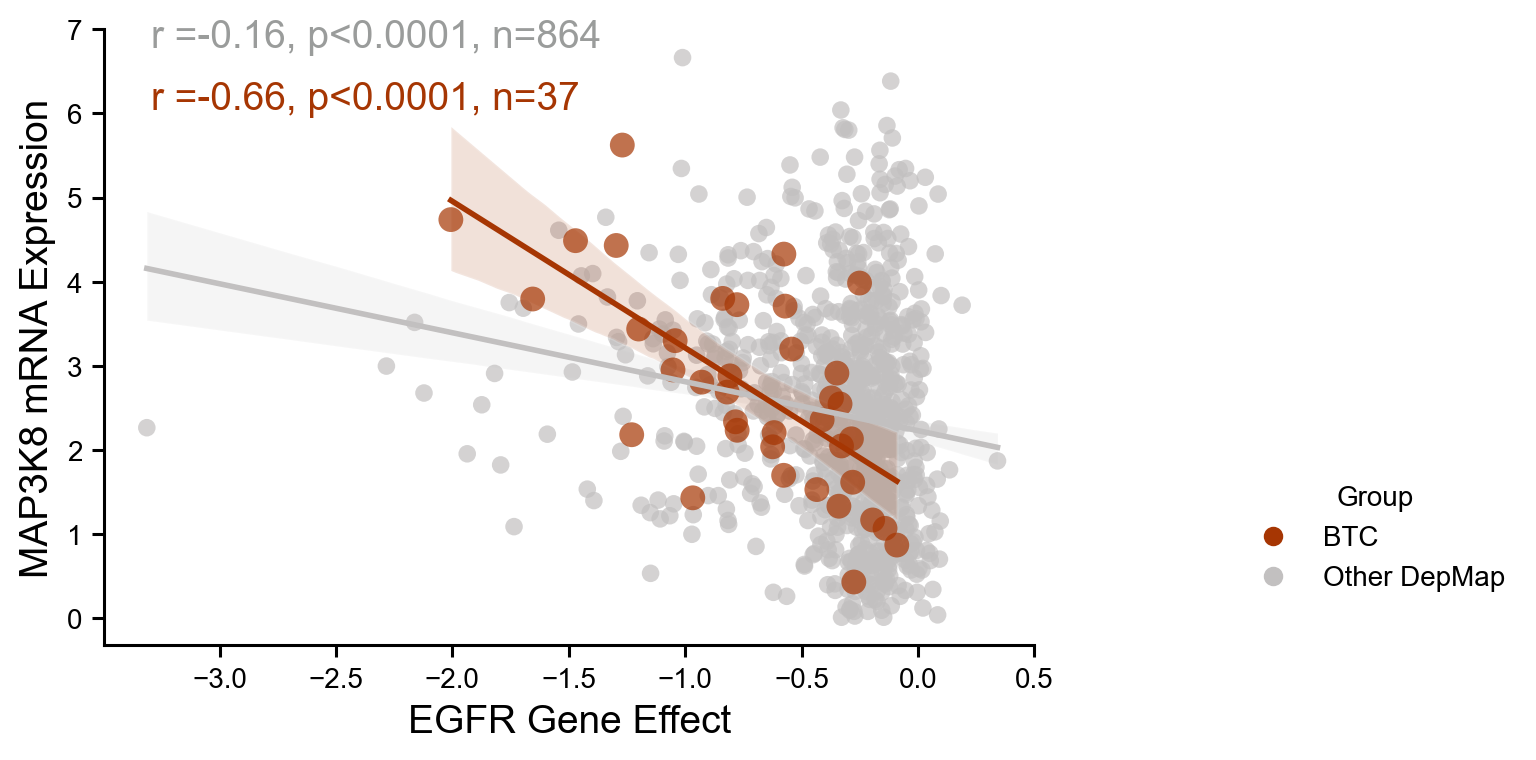

In [65]:
x_gene = 'EGFR'
y_gene = 'MAP3K8'
palette = {'BTC': '#a63603', 'Other DepMap': '#c2c0c0'}
size_dic = {'BTC': 80, 'Other DepMap': 40}
markers_dic = {'BTC':'o', 'Other DepMap':'o'}

x1, y1 = Utils.match_rows_df(other_ccle_crispr_df[[x_gene]], other_ccle_rna_df[[y_gene]])
x2, y2 = Utils.match_rows_df(gene_effect_df[[x_gene]], rna_df[[y_gene]])

df1 = pd.concat([x1, y1], axis=1)
df1.columns = ['gene effect', 'rna']
df1['Group'] = 'Other DepMap'
df1['point_size'] = .01
df2 = pd.concat([x2, y2], axis=1)
df2.columns = ['gene effect', 'rna']
df2['Group'] = 'BTC'
df2['point_size'] = .03

print(df1.shape)
print(df2.shape)

df = pd.concat([df1, df2], axis=0)
MyVisualization.reg_plot_double(data_df=df, x_col='gene effect', y_col='rna', markers_dic=markers_dic, size_dic=size_dic, hue='Group', palette=palette, xlabel=f'EGFR Gene Effect',  ylabel=f'MAP3K8 mRNA Expression', title_height=1.1, text_height=.97, ylim_top=7, xlim_right=0.5,  file_name=f'{x_gene}_{y_gene}')

# B3GALNT2 Protein

In [66]:
gene_effect_df.shape

(39, 17787)

In [67]:
proteomics_file = 'Main_Data/Proteomics/proteomics_collapsed.csv'
proteomics_df = MyLib.load_csv(proteomics_file, index_col=0)
proteomics_df = proteomics_df.T
proteomics_df = proteomics_df.dropna(axis=1, how ='all')

proteomics_filtered_df, gene_effect_filtered_df = Utils.match_rows_df(proteomics_df, gene_effect_df)
proteomics_filtered_df = Clustering.filter_sparse_samples(proteomics_filtered_df, max_allowed_nans_zeros_frac=0.4)
proteomics_mad_filtered_df = proteomics_filtered_df.apply(Clustering.mad_normalize)
proteomics_mad_filtered_df.shape

input_data/Main_Data/Proteomics/proteomics_collapsed.csv  is loaded, shape:  (14411, 75)



(37, 8812)

In [68]:
protein_gene_mapping_file = 'Additional_Data/Selected_Lists/protein_gene_mapping.csv'
protein_gene_mapping_df = MyLib.load_csv(protein_gene_mapping_file, index_col=0)

input_data/Additional_Data/Selected_Lists/protein_gene_mapping.csv  is loaded, shape:  (11421, 1)




File  Figure3/output_fig3/egfr_BTC_protein_corr.csv saved, shape: (8812, 4)


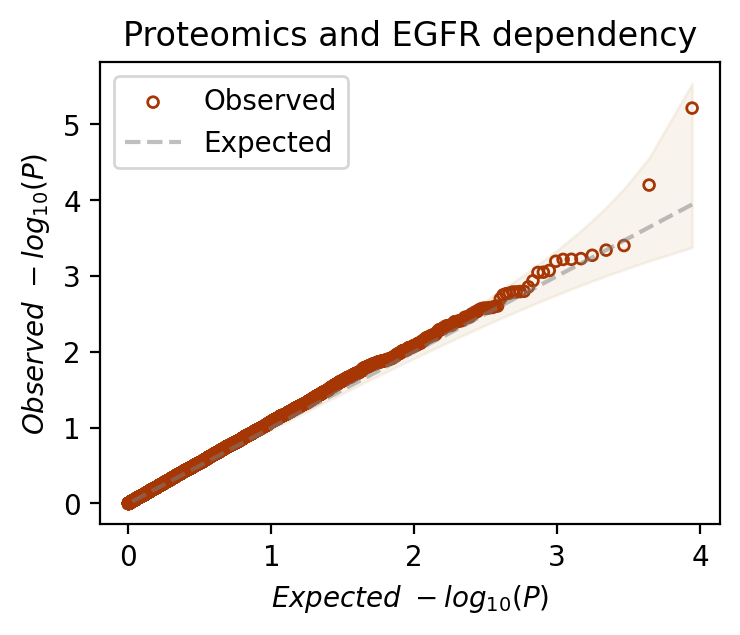

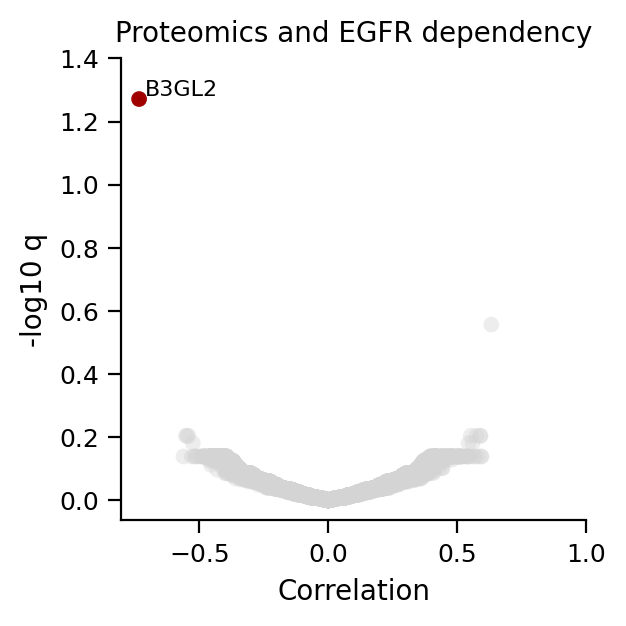

In [69]:
cor_res_df = Utils.statistical_test_and_volcano_plot(gene_effect_df, proteomics_mad_filtered_df, col='EGFR', test='correlation',
                                        force_points=4, title='Proteomics and EGFR dependency', xlim_right=1, ylim_top=1.4, plot_qqplot=True, down_color='#A00000',
                                        cut_off_labels=7, force_text=.5, xlabel='Correlation', save_file='egfr_BTC_protein_corr.csv')

Add gene names to protein IDs

In [70]:
res_file = 'Figure3/output_fig3/egfr_BTC_protein_corr.csv'
res_df = pd.read_csv(res_file, index_col=0)
res_df['GeneName'] = protein_gene_mapping_df.loc[res_df.index]['GeneName'].values
res_df = res_df[['GeneName', 'corr', 'p-value', 'q-value']]
MyLib.save_csv(res_df, 'egfr_BTC_protein_corr.csv')


File  Figure3/output_fig3/egfr_BTC_protein_corr.csv saved, shape: (8812, 4)


In [71]:
df = pd.concat([gene_effect_df['EGFR'], proteomics_mad_filtered_df['B3GL2']], axis=1).dropna(axis=0)
df.head()

,EGFR,B3GL2
SNU869,-0.334542,0.024320
SNU478,-1.296188,2.997911
AOVC1,-0.777736,-1.871188
SNU1196,-0.617907,0.340403
KKU100,-0.371286,-0.892313


In [72]:
res_df.loc['B3GL2']

GeneName    B3GALNT2
corr       -0.733157
p-value     0.000006
q-value     0.053552
Name: B3GL2, dtype: object

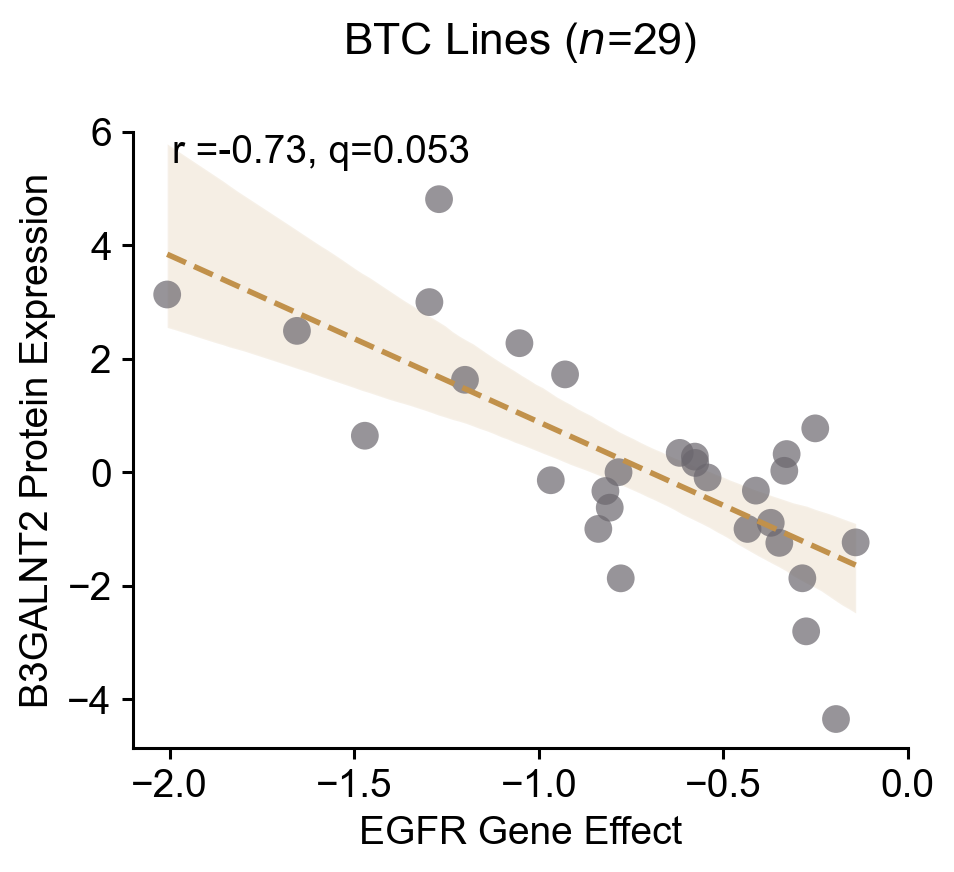

In [73]:
stats_tp = (-0.73, 0.053) # from volcano plot above
MyVisualization.reg_plot(data_df=df, x_col='EGFR',y_col='B3GL2', points_color_code=points_color, line_color_code=line_color, xlabel='EGFR Gene Effect', ylabel='B3GALNT2 Protein Expression', stats_tp=stats_tp, sig_threshold=0.1, marker='o',ylim_top=6, xlim_right=0., text_height=.95,  title=f'BTC Lines ($n$={df.shape[0]})', title_height=1.1, file_name='B3GALNT2_EGFR')